## レポート用のコードとグラフ

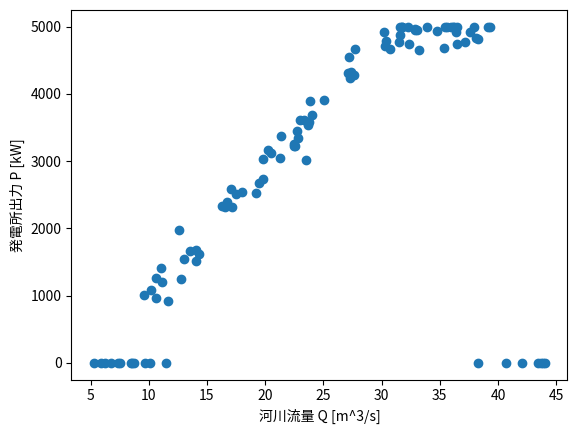

In [4]:
# サンプルデータを生成
# 河川流量に対し発電所出力が比例する仮定
# 引き戻し回路と取水停止を考慮
# 河川流量および発電所出力に誤差を設定

import numpy as np
import matplotlib.pyplot as plt

def pq_curve(q, q_min=10.0, q_max=30.0, q_out=40.0, p_min=1000.0, p_max=5000.0, seed=None):
    rng = np.random.default_rng(seed=seed)
    q = q + rng.normal(0.0, 1.0)
    if q <= q_min:
        p = 0
    elif q >= q_out:
        p = 0
    else:
        a = (p_max - p_min) / (q_max - q_min)
        p = min(p_max, a*(q - q_min) + p_min)
        e = min(0, rng.normal(0.0, 200.0))
        p = p + e
    return p

rng = np.random.default_rng(seed=42)
X = rng.uniform(5.0, 45.0, size=100)
y = np.array([pq_curve(x, seed=rng.integers(1, 999)) for x in X])
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
plt.rcParams['font.family'] = "Noto Sans CJK JP"
plt.scatter(X, y)
plt.xlabel("河川流量 Q [m^3/s]")
plt.ylabel("発電所出力 P [kW]")
plt.show()

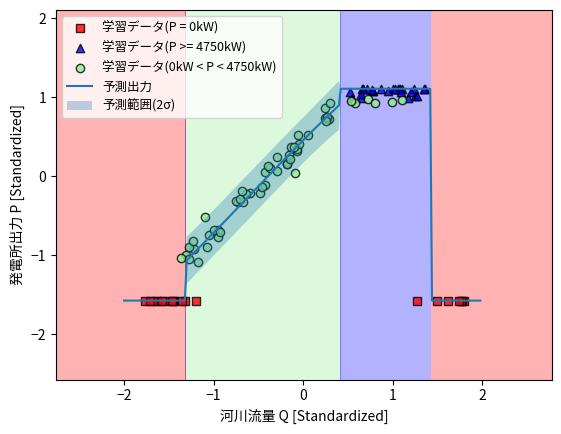

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# 出力値を基に、分類に必要な教師データを作成
def labeling(p_data, p_upper=4750.0):
    labels = []
    for p in p_data.flatten():
        if p == 0:
            labels.append(0)
        elif p >= p_upper:
            labels.append(1)
        else:
            labels.append(2)
    return np.array(labels)

cls = labeling(y)

# サンプルデータを平均0・分散1に標準化
# 標準化により回帰分析モデルがうまく働くようになる
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y).flatten()

# 決定木モデルを使い、運転範囲を3つに分類
# class0: 運転可能範囲外
# class1: 最大負荷運転範囲
# class2: 部分負荷運転範囲
clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(X_std, cls)

# class2（部分負荷運転範囲）の時、ガウス過程回帰を用いて出力を予測
cls2 = clf.predict(X_std)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e+3)) + WhiteKernel() 
rg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
rg.fit(X_std[cls2 == 2], y_std[cls2 == 2])

# 予測結果を関数にまとめる
def hydropower_predict(Q_std, return_std=False):
    P = np.empty(Q_std.shape[0])
    Std = np.empty(Q_std.shape[0])
    Q_cls = clf.predict(Q_std)
    P[Q_cls == 0] = (0.0 - sc_y.mean_) / np.sqrt(sc_y.var_)
    P[Q_cls == 1] = (5000.0 - sc_y.mean_) / np.sqrt(sc_y.var_) 
    if return_std:
        Std[Q_cls == 0] = 0.0
        Std[Q_cls == 1] = 0.0
        P[Q_cls == 2], Std[Q_cls == 2] = rg.predict(Q_std[Q_cls == 2], return_std=True)
        return P, Std
    else:
        P[Q_cls == 2] = rg.predicti(Q_std[Q_cls == 2], return_std=False)
        return P

# 分類結果を表示
def plot_decision_regions(X, y, cls, classifier, resolution=0.02, labels=None):
    markers = ('s', '^', 'o', 'v', 'x')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(cls))])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = y[:].min() - 1, y[:].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                           np.arange(y_min, y_max, resolution))
    Z = classifier.predict(np.array([xx.ravel()]).T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    if not labels: labels = np.unique(cls)
    for idx, cl in enumerate(np.unique(cls)):
        plt.scatter(x=X[cls == cl, 0], y=y[cls == cl], alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=labels[cl], edgecolors='black')

legend_labels = ['学習データ(P = 0kW)', '学習データ(P >= 4750kW)', '学習データ(0kW < P < 4750kW)']
plot_decision_regions(X=X_std, y=y_std, cls=cls, classifier=clf, resolution=0.02, labels=legend_labels)
X_pred = np.arange(-2.0, 2.0, 0.02).reshape(-1, 1)
y_pred, y_pred_std = hydropower_predict(X_pred, return_std=True)
plt.plot(X_pred, y_pred, label="予測出力")
plt.fill_between(
    x=X_pred.flatten(), 
    y1=y_pred + 2.0*y_pred_std,
    y2=y_pred - 2.0*y_pred_std,
    alpha=0.3,
    label="予測範囲(2σ)"
)
plt.rcParams['font.family'] = "Noto Sans CJK JP"
plt.xlabel("河川流量 Q [Standardized]")
plt.ylabel("発電所出力 P [Standardized]")
plt.legend(loc='upper left', fontsize=9)
plt.show()